# Impedance control of a 6 dof manipulator

## Import all the modules needed for the simulation

In [1]:
from pickle import GLOBAL
import pinocchio as pin
import numpy as np
import sys
import os
from pinocchio.visualize import MeshcatVisualizer
import time
import math
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
plt.rcParams['text.usetex'] = True

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<hpp::fcl::CollisionGeometry> already registered; second conversion method ignored.


## Bring the URDF model of the robot 

In [2]:
pinocchio_model_dir = '/home/unknown/Documents/Posdoc/ModelsCads/urdf' 
mesh_dir = pinocchio_model_dir + '/kinova_description/meshes/'
urdf_model_path =pinocchio_model_dir + '/j2s6s200_simple_naomi.urdf'
model, collision_model, visual_model = pin.buildModelsFromUrdf(urdf_model_path, mesh_dir)
# Choose of the visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)

## Identify the frame and joint IDs

In [3]:
frameIndex = model.getFrameId('j2s6s200_end_effector')
jointIndex = model.frames[frameIndex].parent
# Create data required by the algorithms
data     = model.createData()

# Function to plot matrices in matlab way

In [4]:
def mprint(M, name="ans",eps=1e-15):
    '''
    Matlab-style pretty matrix print.
    '''
    if isinstance(M, pin.SE3):
        M = M.homogeneous
    if len(M.shape) == 1:
        M = np.expand_dims(M, axis=0)
    ncol = M.shape[1]
    NC = 6
    print(name, " = ")
    print()

    Mmin = lambda M: M.min()
    Mmax = lambda M: M.max()
    Mm = Mmin(abs(M[np.nonzero(M)]))
    MM = Mmax(abs(M[np.nonzero(M)]))

    fmt = "% 10.4f" if Mm < 1e-5 or MM > 1e6 or MM / Mm > 1e3 else "% 1.5f"
    for i in range(math.floor((ncol - 1) / NC + 1)):
        cmin = i * 6
        cmax = (i + 1) * 6
        cmax = ncol if ncol < cmax else cmax
        print("Columns %s through %s" % (cmin, cmax - 1))
        print()
        for r in range(M.shape[0]):
            sys.stdout.write("  ")
            for c in range(cmin, cmax):
                if abs(M[r,c])>eps: sys.stdout.write(fmt % M[r,c]  + "   ")
                else: sys.stdout.write(" 0"+" "*9)
            print()
        print()

## Initialize the viewer

In [5]:
try:
    viz.initViewer()
except ImportError as err:
    print("Error while initializing the viewer. It seems you should install gepetto-viewer")
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print("Error while loading the viewer model. It seems you should start gepetto-viewer")
    print(err)
    sys.exit(0)
viz.viewer['world'].set_transform(np.array(pin.XYZQUATToSE3([0, 0, 0, 0, 0, 1, 0])))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


# Simulation


## Manipulator dynamic model

\begin{equation}
\mathbf{
M(q)\ddot{q} + C(q,\dot{q})\dot{q} + g(q) = \tau + J(q)^T F_{ext}}
\label{eq:01}
\end{equation}

### Desired interaction model 

\begin{equation}
\mathbf{
M_d\ddot{x} + D_d\dot{x} = \hat{F}_e}
\label{eq:13}
\end{equation}

### The closed loop control law $\tau$ can be written 

\begin{equation}
\mathbf{\tau} = -\mathbf{J^T} \mathbf{\Lambda}[\mathbf{\dot{J}}\mathbf{\dot{q}} + \mathbf{M_d^{-1}}(\mathbf{D_d}\mathbf{\dot{x}}  - \mathbf{\hat{F}_{ext}})] +  \mathbf{g(q)} + \mathbf{C(q,\dot{q})}
\end{equation}
where
\begin{equation}
 \mathbf{\Lambda} =  (\mathbf{JM^{-1}J^T)^{-1}}
\end{equation}

## Control and simulation parameters

In [6]:
# Sample a random configuration
q =np.array([0, 2.9, 1.3, -2.07, 1.4,0]) # Natural position as in the real case
qdot = pin.utils.zero(model.nv) # this is the angular velocity
a = pin.utils.zero(model.nv) # angular acceleration

pin.forwardKinematics(model,data,q)
pin.updateFramePlacements(model,data) #Computes the placement of all the joints
oMdes = data.oMf[model.getFrameId("j2s6s200_end_effector")] # I took the desired pose as the actual one
# This is the pose of the end-effector refered in the frame of the base

## External forces
fx = -2; fy=0; fz=0; nx =0; ny=0; nz=0
fext = []

wrench = np.array([fx,fy,fz,nx,ny,nz])
wrench_ = pin.Force.Zero()
wrench_.linear = np.array([fx,fy,fz])
wrench_.angular = np.array([nx,ny,nz])

for k in range(model.njoints):
    faux = pin.Force.Zero()
    if k == (model.njoints-1):
        faux.linear = wrench_.linear
        faux.angular =wrench_.angular
    fext.append(faux)

d1 =20; d2 =20;  d3 =20; d4 =0.85; d5 =0.85;  d6 =0.85
ds = np.array([d1, d2, d3, d4, d5, d6])
Dd = np.diag(ds) #  Damper Matrix

md1 =10; md2 =10;  md3 =10; md4 =0.21; md5 =0.21;  md6 =0.21
mds = np.array([md1, md2, md3, md4, md5, md6])
Md = np.diag(mds) # Mass Matrix

# for runing the simulation
t = 0
dt = 1e-2
T = 5
N = math.floor(T/dt) 
# for graphs
t_list = []
u_list = []
q_list = [] #q
pose_list = []
pose_des_list = []
    

## Run simulation 

In [7]:
## for runing the simulation
for k in range(N):
    t += dt
    tic = time.time()

    pin.forwardKinematics(model,data,q)
    pin.updateFramePlacements(model,data)
    OM_act = data.oMf[frameIndex] # This is the pose of the end-effector refered in the frame of the base

    pin.computeJointJacobians(model, data, q)
    J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED) #Jacobian in the frame of the base
    dJ = pin.computeJointJacobiansTimeVariation(model,data,q,qdot) # Derivative of the Jacobian
    xdot = J@qdot
    velerror = -xdot
    # Compute torque control
    u = Dd@velerror + wrench
    a =  J.T@(dJ@qdot+np.linalg.pinv(Md)@u)
    tau = pin.rnea(model, data, q, qdot, a, fext)
    # Compute forward dynamics
    qddot = pin.aba(model, data, q, qdot, tau, fext)

    qdot += a * dt
    q = pin.integrate(model,q,qdot*dt)

    pos = np.array([OM_act.translation[0],OM_act.translation[1],OM_act.translation[2]])
    viz.display(q)
    q_list.append(q)
    pose_list.append(pos)
    pose_des_list.append(oMdes.translation)
    t_list.append(t)
    u_list.append(a)

    toc = time.time()
    ellapsed = toc - tic
    dt_sleep = max(0,dt - (ellapsed))
    time.sleep(dt_sleep)
        
t_list = np.array(t_list)
u_list = np.array(u_list)
q_list = np.array(q_list)
pose_list = np.array(pose_list)
pose_des_list = np.array(pose_des_list)

In [8]:
isinstance(viz, pin.visualize.MeshcatVisualizer) and viz.viewer.jupyter_cell()

## Graphs functions ($\tau$, $q$, ($\xi_{ee},\eta_{ee})$)

In [9]:

def graphs_qs(t_list, q_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, q_list[:, :])
    plt.grid(True)
    ax.set_ylabel(r"$q \ [rad]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$q_0$",r"$q_1$",r"$q_2$",r"$q_3$",r"$q_4$",r"$q_5$"),loc="upper right")
    fig.tight_layout()
    plt.show()

def graphs_taus(t, tau):
    fig, ax = plt.subplots()
    ax = plt.subplot(3, 2, 1)
    plt.plot(t, tau[:, 0])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_0 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 2)
    plt.plot(t, tau[:, 1])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_1 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 3)
    plt.plot(t, tau[:, 2])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_2 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 4)
    plt.plot(t, tau[:, 3])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_3 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 5)
    plt.plot(t, tau[:, 4])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_4 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 6)
    plt.plot(t, tau[:, 5])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_5 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    plt.show()

def graphs_pose(t, pose, pose_des):
    fig, ax = plt.subplots()
    ax = plt.subplot(3, 1, 1)
    plt.plot(t, pose[:, 0])
    plt.plot(t, pose_des[:, 0],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$x \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$x$",r"$x_{d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 1, 2)
    plt.plot(t, pose[:, 1])
    plt.plot(t, pose_des[:, 1],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$y \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$y$",r"$y_{d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 1, 3)
    plt.plot(t, pose[:, 2])
    plt.plot(t, pose_des[:, 2],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$z \ [m]$", fontsize = 14)
    ax.set_ylim(0, 0.9)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$z$",r"$z_{d}$"),loc="upper right")
    fig.tight_layout()
    plt.show()

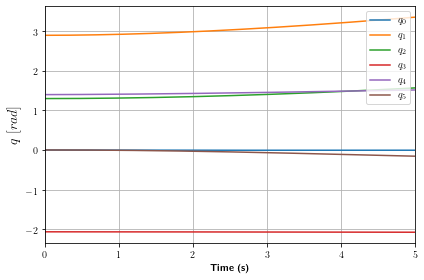

In [10]:
graphs_qs(t_list, q_list)

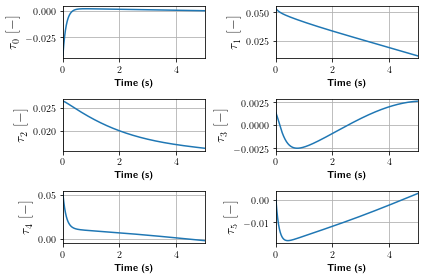

In [11]:
graphs_taus(t_list, u_list)

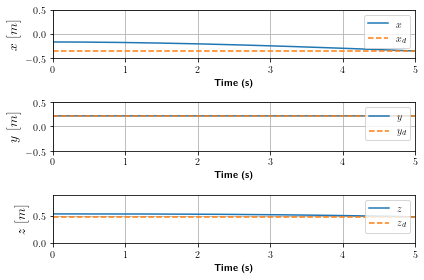

In [12]:
graphs_pose(t_list, pose_list, pose_des_list)